## 📘 Tutorial: Análise de Sentimentos em Tweets em Português com spaCy

### 🔹 1. Instalação e Preparação do Ambiente

Instale as bibliotecas necessárias:

In [36]:
%pip install spacy seaborn enelvo imbalanced-learn nltk --quiet
!python -m spacy download pt_core_news_lg --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


Importe as bibliotecas:

In [37]:
import spacy
import pandas as pd
import seaborn as sns
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem.snowball import SnowballStemmer
import os

In [38]:
os.makedirs("corpus", exist_ok=True)
os.makedirs("output_model", exist_ok=True)


### 🔹 2. Carregamento e Visualização do Dataset

Carregue o dataset:

In [39]:
df = pd.read_csv(
    "dataset/NoThemeTweets.csv"
)
df["sentiment"] = df["sentiment"].replace({"Positivo": 1, "Negativo": 0})
df["sentiment"] = df["sentiment"].astype("category")
df.head()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_87608/4097103714.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sentiment"] = df["sentiment"].replace({"Positivo": 1, "Negativo": 0})


,id,tweet_text,tweet_date,sentiment,query_used
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,1,:)
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,1,:)
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,1,:)
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,1,:)
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,1,:)


Visualize a distribuição das classes:([kaggle.com][1])

<Axes: xlabel='sentiment', ylabel='count'>

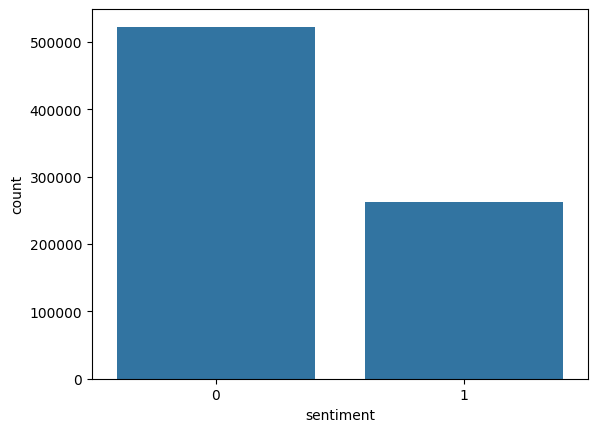

In [40]:
sns.countplot(x=df["sentiment"])

### 🔹 3. Balanceamento das Classes

Utilize o `RandomUnderSampler` para balancear as classes:

<Axes: xlabel='sentiment', ylabel='count'>

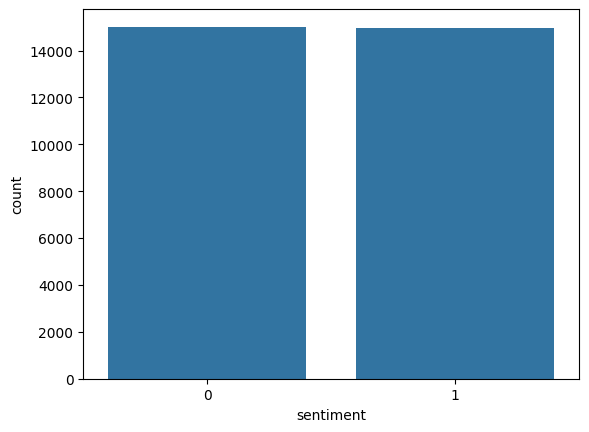

In [41]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df[["tweet_text"]], df["sentiment"])
df_balanced = pd.DataFrame(X_resampled, columns=["tweet_text"])
df_balanced["sentiment"] = y_resampled
df_balanced = shuffle(df_balanced, random_state=42)
df_balanced = df_balanced[:30000]  # Redução para exemplificação
sns.countplot(x=df_balanced["sentiment"])

### 🔹 4. Pré-processamento dos Dados

Defina funções para limpeza textual:

In [42]:
nlp = spacy.load("pt_core_news_lg")
stemmer = SnowballStemmer(language="portuguese")


def remove_patterns(texto):
    texto = re.sub(r":[)(]+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#\w+", "", texto)
    return texto


def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])


def stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)


def lemmatization(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

Aplique as técnicas de pré-processamento:

In [43]:
df_patterns = df_balanced.copy()
df_patterns["tweet_text"] = df_patterns["tweet_text"].apply(remove_patterns)

df_stop_words = df_patterns.copy()
df_stop_words["tweet_text"] = df_stop_words["tweet_text"].apply(remove_stopwords)

df_lemmatization = df_patterns.copy()
df_lemmatization["tweet_text"] = df_lemmatization["tweet_text"].apply(lemmatization)

df_stemming = df_patterns.copy()
df_stemming["tweet_text"] = df_stemming["tweet_text"].apply(stemming)

### 🔹 5. Conversão para Formato spaCy

Prepare os dados para o spaCy:

In [44]:
from spacy.tokens import DocBin

def convert(data, outfile):
    db = DocBin()
    for doc, label in nlp.pipe(data, as_tuples=True):
        doc.cats["POS"] = label == 1
        doc.cats["NEG"] = label == 0
        db.add(doc)
    db.to_disk(outfile)

Divida os dados e converta:([kaggle.com][1])

In [45]:
dataset = list(
    df_patterns[["tweet_text", "sentiment"]]
    .sample(frac=1)
    .itertuples(index=False, name=None)
)
train, test_dev = train_test_split(dataset, test_size=0.3, random_state=42)
test, dev = train_test_split(test_dev, test_size=0.5, random_state=42)

# Salva arquivos convertidos na pasta 'corpus'
convert(train, "corpus/train.spacy")
convert(dev, "corpus/dev.spacy")
convert(test, "corpus/test.spacy")

### 🔹 6. Configuração e Treinamento do Modelo

Inicialize a configuração do spaCy:

In [46]:
!python -m spacy init config --lang pt --pipeline textcat --force configs/config.cfg

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: pt
- Pipeline: textcat
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
configs/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Treine o modelo:

In [47]:
!python -m spacy train configs/config.cfg \
  --output output_model/ \
  --paths.train corpus/train.spacy \
  --paths.dev corpus/dev.spacy \
  --training.patience 1200


ℹ Saving to output directory: output_model
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.25       55.88    0.56
  0     200         45.22       70.25    0.70
  0     400         40.56       72.75    0.73
  0     600         37.08       74.46    0.74
  0     800         35.79       75.08    0.75
  0    1000         34.05       76.65    0.77
  0    1200         32.87       77.89    0.78
  0    1400         32.24       77.62    0.78
  1    1600         26.40       78.06    0.78
  1    1800         25.29       78.16    0.78
  2    2000         24.40       78.75    0.79
  2    2200         21.52       79.06    0.79
  3    2400        

### 🔹 7. Avaliação do Modelo

Avalie o desempenho do modelo:([arxiv.org][2])

In [48]:
!python -m spacy evaluate output_model/model-best corpus/test.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   78.82 
SPEED               398333


=========================== Textcat F (per label) ===========================

          P       R       F
POS   80.68   75.72   78.12
NEG   77.23   81.95   79.52


======================== Textcat ROC AUC (per label) ========================

      ROC AUC
POS      0.87
NEG      0.87



## 📊 Resultados e Análise

Os resultados variam conforme a técnica de pré-processamento aplicada. Por exemplo:

* **Sem remoção de padrões**: F1-score de aproximadamente 99.78%, indicando possível overfitting devido à presença de emoticons como ":)" e ":(".
* **Com remoção de padrões**: F1-score reduzido para cerca de 77.28%, refletindo uma avaliação mais realista do modelo.
* **Com remoção de stop words**: F1-score em torno de 76.77%.
* **Com lematização**: F1-score de aproximadamente 77.30%.
* **Com stemming**: F1-score de cerca de 76.99%.

Esses resultados destacam a importância do pré-processamento adequado e a necessidade de considerar o contexto dos dados ao treinar modelos de análise de sentimentos.


## 📦 1. Carregar o modelo treinado e 💬 Função para classificar sentimentos

In [49]:
import spacy

# Carrega o modelo treinado
nlp = spacy.load("output_model/model-best")

def classificar_sentimento(texto):
    doc = nlp(texto)
    scores = doc.cats
    sentimento = "Positivo" if scores["POS"] > scores["NEG"] else "Negativo"
    confianca = scores["POS"] if sentimento == "Positivo" else scores["NEG"]
    return sentimento, round(confianca, 3)

## 2. Testes com exemplos fixos

In [50]:
exemplos = [
    "Adorei o serviço, chegou tudo certinho!",
    "Estou muito decepcionado com a entrega.",
    "Mais ou menos... poderia ser melhor.",
    "Ganhei um cupom de desconto e fiquei feliz :)",
    "O produto veio com defeito e ninguém resolve.",
]

for texto in exemplos:
    sentimento, score = classificar_sentimento(texto)
    print(f"Texto: {texto}\n→ Sentimento: {sentimento} (confiança: {score})\n")

Texto: Adorei o serviço, chegou tudo certinho!
→ Sentimento: Positivo (confiança: 0.653)

Texto: Estou muito decepcionado com a entrega.
→ Sentimento: Positivo (confiança: 0.636)

Texto: Mais ou menos... poderia ser melhor.
→ Sentimento: Positivo (confiança: 0.737)

Texto: Ganhei um cupom de desconto e fiquei feliz :)
→ Sentimento: Positivo (confiança: 0.733)

Texto: O produto veio com defeito e ninguém resolve.
→ Sentimento: Positivo (confiança: 0.695)

